**Part 1 U-Net Model Segmentation**

In [1]:
import os
import cv2
import glob
import PIL
import shutil
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from skimage import data
from skimage.util import montage
import skimage.transform as skTrans
from skimage.transform import rotate
from skimage.transform import resize
from PIL import Image, ImageOps
import nilearn as nl
import nibabel as nib

# ml libs
import keras
import keras.backend as K
from keras.callbacks import CSVLogger
import tensorflow as tf
from tensorflow.keras.utils import plot_model
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, TensorBoard




np.set_printoptions(precision=3, suppress=True)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
"""
Label definition and required parameters
"""
SEGMENT_CLASSES = {
0 : 'No Tumor',
1 : 'Necrotic/Nuclear', #Tumor Nucleus
2 : 'Edema',#Edema Part
3 : 'Expanding Tumor' #Expanding Tumor Part
}

IMG_SIZE=64


VOLUME_SLICES = 100
VOLUME_START_AT = 22 

In [3]:
# Verilerin ön incelenmesi ve görselleştirilmesi
TRAIN_DATASET_PATH = '/kaggle/input/brain-tumor-segmentation-brats-2019/MICCAI_BraTS_2019_Data_Training/HGG'
VALIDATION_DATASET_PATH = '/kaggle/input/brain-tumor-segmentation-brats-2019/MICCAI_BraTS_2019_Data_Training/LGG'


In [4]:
"""Bu kod, böbrek ve beyin tümörlerinin segmentasyonu için Dice katsayısı, doğruluk, duyarlılık ve özgüllük gibi değerlerin hesaplanmasını sağlar.
dice_coef fonksiyonu, verilen gerçek ve tahmini etiketler arasında Dice katsayısını hesaplar ve döndürür. 
dice_coef_necrotic, dice_coef_edema ve dice_coef_enhancing fonksiyonları ise sırasıyla nekrotik, ödemli ve genişleyen tümör bölgeleri için 
Dice katsayısını hesaplar.precision fonksiyonu, verilen gerçek ve tahmini etiketler arasında doğruluk değerini hesaplar ve döndürür.
sensitivity fonksiyonu, verilen gerçek etiketler ve tahmini etiketler arasında duyarlılık değerini hesaplar ve döndürür.
specificity fonksiyonu ise verilen gerçek etiketler ve tahmini etiketler arasında özgüllük değerini hesaplar ve döndürür."""

def dice_coef(y_true, y_pred, smooth=1.0):
    class_num = 4
    for i in range(class_num):
        y_true_f = K.flatten(y_true[:,:,:,i])
        y_pred_f = K.flatten(y_pred[:,:,:,i])
        intersection = K.sum(y_true_f * y_pred_f)
        loss = ((2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth))
  
        if i == 0:
            total_loss = loss
        else:
            total_loss = total_loss + loss
    total_loss = total_loss / class_num
    return total_loss


def dice_coef_necrotic(y_true, y_pred, epsilon=1e-6):
    intersection = K.sum(K.abs(y_true[:,:,:,1] * y_pred[:,:,:,1]))
    return (2. * intersection) / (K.sum(K.square(y_true[:,:,:,1])) + K.sum(K.square(y_pred[:,:,:,1])) + epsilon)

def dice_coef_edema(y_true, y_pred, epsilon=1e-6):
    intersection = K.sum(K.abs(y_true[:,:,:,2] * y_pred[:,:,:,2]))
    return (2. * intersection) / (K.sum(K.square(y_true[:,:,:,2])) + K.sum(K.square(y_pred[:,:,:,2])) + epsilon)

def dice_coef_enhancing(y_true, y_pred, epsilon=1e-6):
    intersection = K.sum(K.abs(y_true[:,:,:,3] * y_pred[:,:,:,3]))
    return (2. * intersection) / (K.sum(K.square(y_true[:,:,:,3])) + K.sum(K.square(y_pred[:,:,:,3])) + epsilon)



def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision


def sensitivity(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())


def specificity(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1-y_true) * (1-y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1-y_true, 0, 1)))
    return true_negatives / (possible_negatives + K.epsilon())

In [5]:
import os
os.listdir(TRAIN_DATASET_PATH)
os.listdir(VALIDATION_DATASET_PATH)

['BraTS19_TCIA10_632_1',
 'BraTS19_2013_16_1',
 'BraTS19_TCIA10_202_1',
 'BraTS19_TCIA10_628_1',
 'BraTS19_TCIA10_629_1',
 'BraTS19_TCIA10_420_1',
 'BraTS19_TCIA10_625_1',
 'BraTS19_TCIA10_644_1',
 'BraTS19_2013_6_1',
 'BraTS19_TCIA13_618_1',
 'BraTS19_TCIA13_633_1',
 'BraTS19_TCIA09_493_1',
 'BraTS19_TCIA10_490_1',
 'BraTS19_TCIA12_480_1',
 'BraTS19_2013_9_1',
 'BraTS19_TCIA13_630_1',
 'BraTS19_TCIA10_109_1',
 'BraTS19_TCIA13_654_1',
 'BraTS19_TCIA09_254_1',
 'BraTS19_2013_1_1',
 'BraTS19_TCIA13_624_1',
 'BraTS19_TCIA10_639_1',
 'BraTS19_TCIA13_645_1',
 'BraTS19_TCIA09_462_1',
 'BraTS19_TCIA10_130_1',
 'BraTS19_TCIA10_261_1',
 'BraTS19_TCIA10_413_1',
 'BraTS19_TCIA12_298_1',
 'BraTS19_TCIA09_255_1',
 'BraTS19_TCIA10_299_1',
 'BraTS19_TCIA13_650_1',
 'BraTS19_TCIA10_408_1',
 'BraTS19_TCIA09_428_1',
 'BraTS19_TCIA10_637_1',
 'BraTS19_TCIA10_351_1',
 'BraTS19_TCIA09_451_1',
 'BraTS19_TCIA09_620_1',
 'BraTS19_TCIA10_387_1',
 'BraTS19_TCIA12_470_1',
 'BraTS19_TCIA10_266_1',
 'BraTS19_TCIA0

In [6]:
print(len(os.listdir(TRAIN_DATASET_PATH)))
print(len(os.listdir(VALIDATION_DATASET_PATH)))

259
76


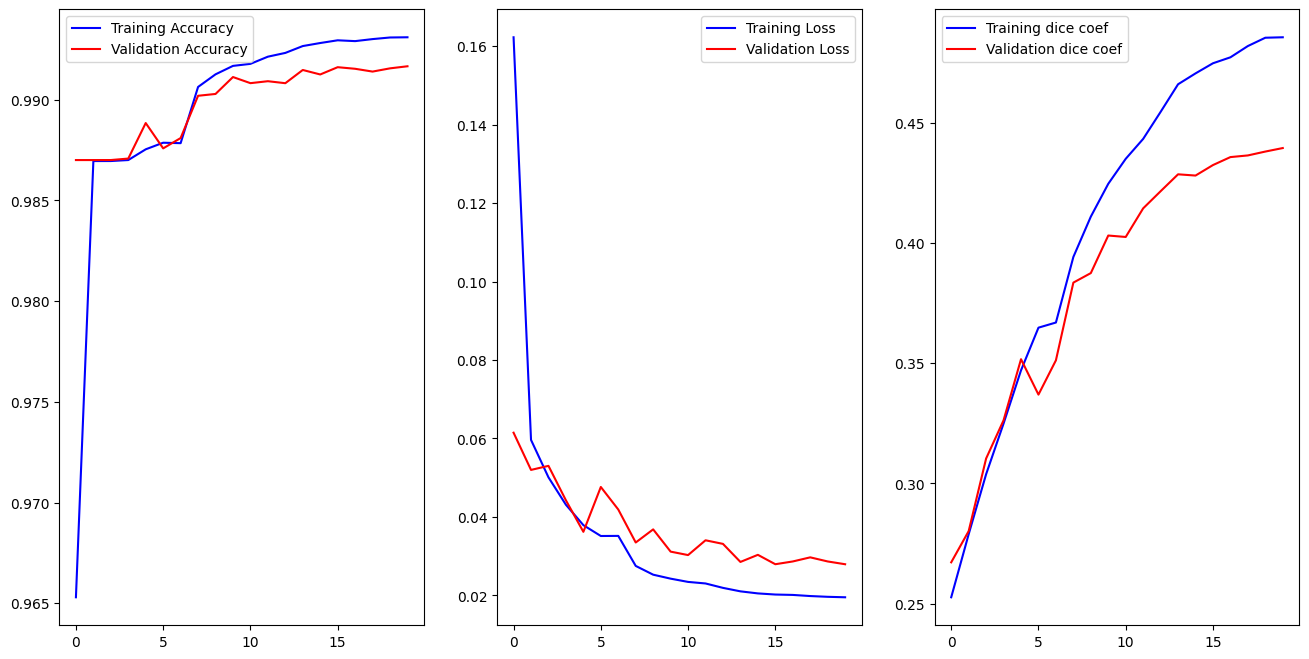

In [7]:
#Modelin yüklenmesi
#Modelin tahmin aşamasında kullanması için eğitim sonrası değerleri tekrar yükledik.
model = keras.models.load_model('/kaggle/input/bratsparts/u-net_part1.h5', 
                                   custom_objects={ 'accuracy' : tf.keras.metrics.MeanIoU(num_classes=4),
                                                   "dice_coef": dice_coef,
                                                   "precision": precision,
                                                   "sensitivity":sensitivity,
                                                   "specificity":specificity,
                                                   "dice_coef_necrotic": dice_coef_necrotic,
                                                   "dice_coef_edema": dice_coef_edema,
                                                   "dice_coef_enhancing": dice_coef_enhancing
                                                  }, compile=False)

#Eğitim sonrası bize grafikleri verdi 
history = pd.read_csv('/kaggle/input/bratsparts/egitim_part1.log', sep=',', engine='python')

hist=history



acc=hist['accuracy']
val_acc=hist['val_accuracy']

epoch=range(len(acc))

loss=hist['loss']
val_loss=hist['val_loss']

train_dice=hist['dice_coef']
val_dice=hist['val_dice_coef']

f,ax=plt.subplots(1,3,figsize=(16,8))

ax[0].plot(epoch,acc,'b',label='Training Accuracy')
ax[0].plot(epoch,val_acc,'r',label='Validation Accuracy')
ax[0].legend()

ax[1].plot(epoch,loss,'b',label='Training Loss')
ax[1].plot(epoch,val_loss,'r',label='Validation Loss')
ax[1].legend()

ax[2].plot(epoch,train_dice,'b',label='Training dice coef')
ax[2].plot(epoch,val_dice,'r',label='Validation dice coef')
ax[2].legend()


plt.show()

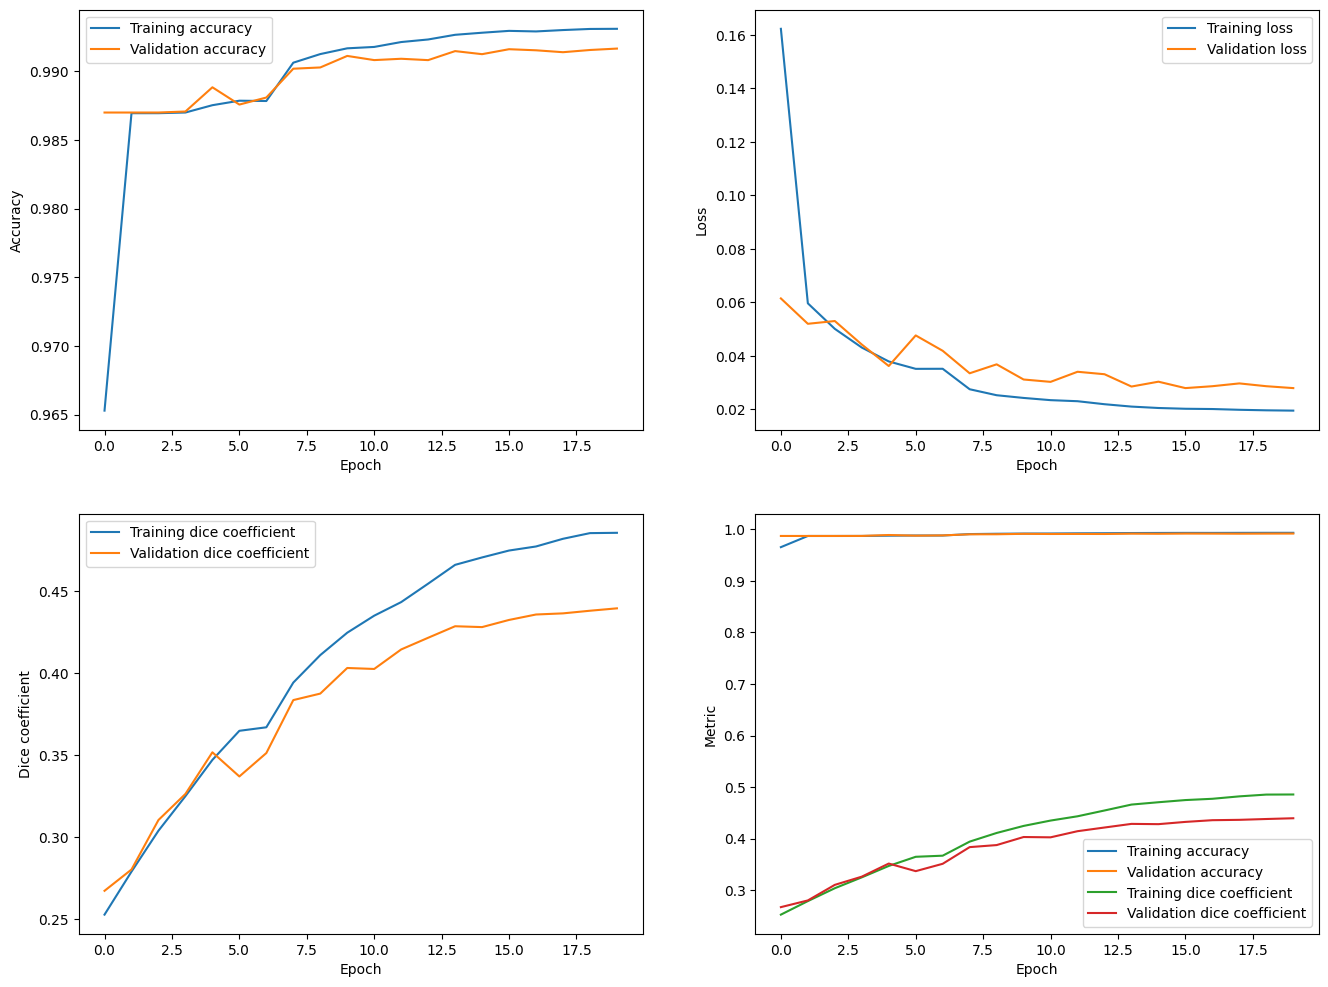

In [8]:
# Load the model
model = keras.models.load_model('/kaggle/input/bratsparts/u-net_part1.h5', 
                                custom_objects={ 'accuracy' : tf.keras.metrics.MeanIoU(num_classes=4),
                                                "dice_coef": dice_coef,
                                                "precision": precision,
                                                "sensitivity":sensitivity,
                                                "specificity":specificity,
                                                "dice_coef_necrotic": dice_coef_necrotic,
                                                "dice_coef_edema": dice_coef_edema,
                                                "dice_coef_enhancing": dice_coef_enhancing
                                               }, compile=False)

# Load the training history
history = pd.read_csv('/kaggle/input/bratsparts/egitim_part1.log', sep=',', engine='python')

# Plot the performance metrics
f, ax = plt.subplots(2, 2, figsize=(16, 12))

ax[0, 0].plot(history['accuracy'], label='Training accuracy')
ax[0, 0].plot(history['val_accuracy'], label='Validation accuracy')
ax[0, 0].set_xlabel('Epoch')
ax[0, 0].set_ylabel('Accuracy')
ax[0, 0].legend()

ax[0, 1].plot(history['loss'], label='Training loss')
ax[0, 1].plot(history['val_loss'], label='Validation loss')
ax[0, 1].set_xlabel('Epoch')
ax[0, 1].set_ylabel('Loss')
ax[0, 1].legend()

ax[1, 0].plot(history['dice_coef'], label='Training dice coefficient')
ax[1, 0].plot(history['val_dice_coef'], label='Validation dice coefficient')
ax[1, 0].set_xlabel('Epoch')
ax[1, 0].set_ylabel('Dice coefficient')
ax[1, 0].legend()

ax[1, 1].plot(history['accuracy'], label='Training accuracy')
ax[1, 1].plot(history['val_accuracy'], label='Validation accuracy')
ax[1, 1].plot(history['dice_coef'], label='Training dice coefficient')
ax[1, 1].plot(history['val_dice_coef'], label='Validation dice coefficient')
ax[1, 1].set_xlabel('Epoch')
ax[1, 1].set_ylabel('Metric')
ax[1, 1].legend()

plt.show()


In [9]:
""" verilen mr tipleri bunlardan birisi olmalıdır         1) flair -- 2) t1-- 3) t1ce -- 4) -- t2  5) seg 
Girdi olarak verilen dosya tahmin edilebilir hale çeviriliyor"""
def imageLoader(path):
    image = nib.load(path).get_fdata()
    X = np.zeros((self.batch_sizeVOLUME_SLICES,self.dim, self.n_channels))
    for j in range(VOLUME_SLICES):
        X[j +VOLUME_SLICESc,:,:,0] = cv2.resize(image[:,:,j+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE));
        X[j +VOLUME_SLICESc,:,:,1] = cv2.resize(ce[:,:,j+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE));

        y[j +VOLUME_SLICESc] = seg[:,:,j+VOLUME_START_AT];
    return np.array(image)

"""Bu fonksiyon, bir dizin yoludur, veri dosyalarının bulunduğu alt dizinlerin listesi ve yüklenen MRI görüntülerinin türü gibi argümanlar alır. 
Daha sonra, veri ve maske dosyalarını okur, yeniden boyutlandırır ve scans ve masks listelerine ekler. 
Bu listeler daha sonra numpy dizileri olarak döndürülür.Bunu da veriyi dizinden yüklemek için kullanıyoruz. """

def loadDataFromDir(path, list_of_files, mriType, n_images):
    scans = []
    masks = []
    for i in list_of_files[:n_images]:
        fullPath = glob.glob( i + '/'+ mriType +'')[0]
        currentScanVolume = imageLoader(fullPath)
        currentMaskVolume = imageLoader( glob.glob( i + '/seg*')[0] ) 
        
        for j in range(0, currentScanVolume.shape[2]):
            scan_img = cv2.resize(currentScanVolume[:,:,j], dsize=(IMG_SIZE,IMG_SIZE), interpolation=cv2.INTER_AREA).astype('uint8')
            mask_img = cv2.resize(currentMaskVolume[:,:,j], dsize=(IMG_SIZE,IMG_SIZE), interpolation=cv2.INTER_AREA).astype('uint8')
            scans.append(scan_img[..., np.newaxis])
            masks.append(mask_img[..., np.newaxis])
    return np.array(scans, dtype='float32'), np.array(masks, dtype='float32')



4/4 [==============================] - 2s 410ms/step


<Figure size 1800x5000 with 0 Axes>

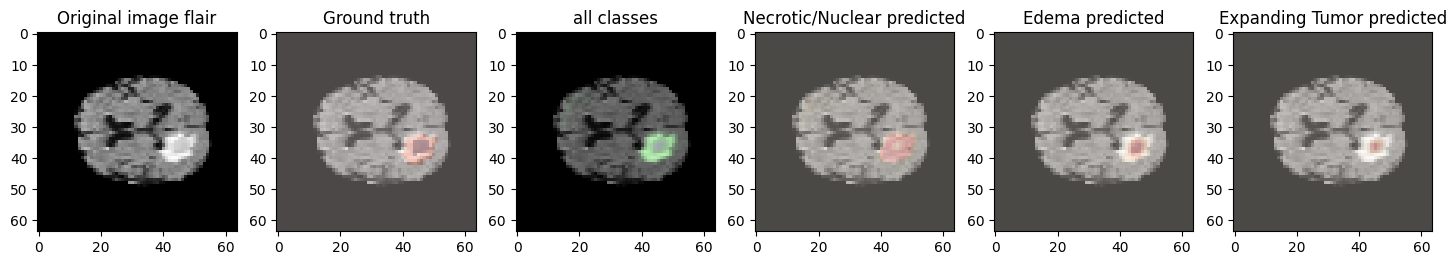

In [10]:
"""Bu kod, eğitilmiş bir modeli kullanarak bir dizinde saklanan MRI taramaları üzerinde tahminler yapmaya yönelik görünüyor.
Önce nib.load fonksiyonunu kullanarak tarama verilerini yükler.
Daha sonra, cv2.resize kullanılarak taramalar yeniden boyutlandırılır ve X olarak adlandırılan 3D bir diziye kaydedilir. 
predictByPath fonksiyonu daha sonra modeli kullanarak X üzerinde tahminler yapar ve tahminleri bir dizi olarak döndürür.
showPredictsById fonksiyonu, modelin yaptığı tahminleri görselleştirmeyi amaçlı görünüyor. Bu fonksiyon, taramalar için ground truth verilerini yükler"""


def predictByPath(case_path,case):
    files = next(os.walk(case_path))[2]
    X = np.empty((VOLUME_SLICES, IMG_SIZE, IMG_SIZE, 2))

    vol_path = os.path.join(case_path, f'BraTS19_2013_{case}_flair.nii');
    flair=nib.load(vol_path).get_fdata()

    vol_path = os.path.join(case_path, f'BraTS19_2013_{case}_t1ce.nii');
    ce=nib.load(vol_path).get_fdata() 

    for j in range(VOLUME_SLICES):
        X[j,:,:,0] = cv2.resize(flair[:,:,j+VOLUME_START_AT], (IMG_SIZE,IMG_SIZE))
        X[j,:,:,1] = cv2.resize(ce[:,:,j+VOLUME_START_AT], (IMG_SIZE,IMG_SIZE))
  
    return model.predict(X/np.max(X), verbose=1)

def showPredictsById(case, start_slice = 60):
    path = f"/kaggle/input/brain-tumor-segmentation-brats-2019/MICCAI_BraTS_2019_Data_Training/HGG/BraTS19_2013_{case}"
    gt = nib.load(os.path.join(path, f'BraTS19_2013_{case}_seg.nii')).get_fdata()
    origImage = nib.load(os.path.join(path, f'BraTS19_2013_{case}_flair.nii')).get_fdata()
    p = predictByPath(path,case)

    core = p[:,:,:,1]
    edema= p[:,:,:,2]
    enhancing = p[:,:,:,3]

    plt.figure(figsize=(18, 50))
    f, axarr = plt.subplots(1,6, figsize = (18, 50)) 

    for i in range(6):
        axarr[i].imshow(cv2.resize(origImage[:,:,start_slice+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE)),cmap="gray", interpolation='none')

    axarr[0].imshow(cv2.resize(origImage[:,:,start_slice+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE)), cmap="gray")
    axarr[0].title.set_text('Original image flair')
    curr_gt=cv2.resize(gt[:,:,start_slice+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE), interpolation = cv2.INTER_NEAREST)
    axarr[1].imshow(curr_gt, cmap="Reds", interpolation='none', alpha=0.3) # ,alpha=0.3,cmap='Reds'
    axarr[1].title.set_text('Ground truth')
    axarr[2].imshow(p[start_slice,:,:,1:4], cmap="Reds", interpolation='none', alpha=0.3)
    axarr[2].title.set_text('all classes')
    axarr[3].imshow(edema[start_slice,:,:], cmap="OrRd", interpolation='none', alpha=0.3)
    axarr[3].title.set_text(f'{SEGMENT_CLASSES[1]} predicted')
    axarr[4].imshow(core[start_slice,:,], cmap="OrRd", interpolation='none', alpha=0.3)
    axarr[4].title.set_text(f'{SEGMENT_CLASSES[2]} predicted')
    axarr[5].imshow(enhancing[start_slice,:,], cmap="OrRd", interpolation='none', alpha=0.3)
    axarr[5].title.set_text(f'{SEGMENT_CLASSES[3]} predicted')
    plt.show()


showPredictsById(case="5_1")#veri deneme


**Part 2 U-Net Model Segmentation**

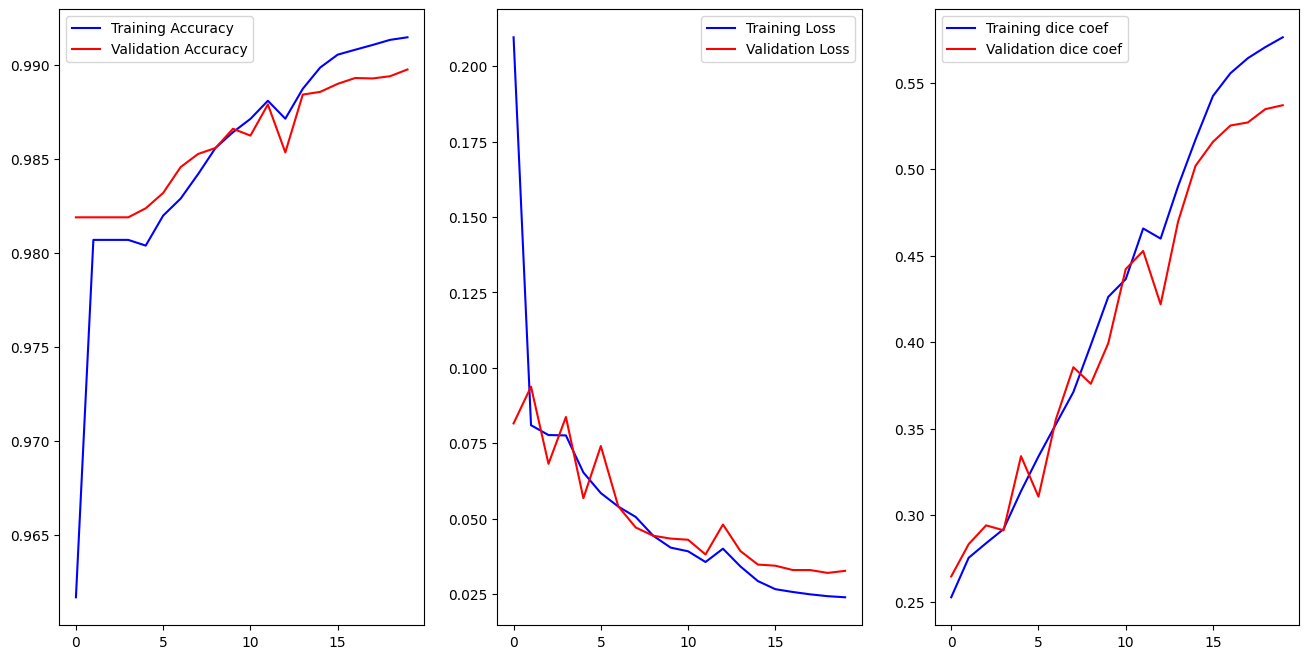

In [11]:
#Modelin yüklenmesi
#Modelin tahmin aşamasında kullanması için eğitim sonrası değerleri tekrar yükledik.
model = keras.models.load_model('/kaggle/input/bratsparts/u-net_part2.h5', 
                                   custom_objects={ 'accuracy' : tf.keras.metrics.MeanIoU(num_classes=4),
                                                   "dice_coef": dice_coef,
                                                   "precision": precision,
                                                   "sensitivity":sensitivity,
                                                   "specificity":specificity,
                                                   "dice_coef_necrotic": dice_coef_necrotic,
                                                   "dice_coef_edema": dice_coef_edema,
                                                   "dice_coef_enhancing": dice_coef_enhancing
                                                  }, compile=False)

#Eğitim sonrası bize grafikleri verdi 
history = pd.read_csv('/kaggle/input/bratsparts/egitim_part2.log', sep=',', engine='python')

hist=history



acc=hist['accuracy']
val_acc=hist['val_accuracy']

epoch=range(len(acc))

loss=hist['loss']
val_loss=hist['val_loss']

train_dice=hist['dice_coef']
val_dice=hist['val_dice_coef']

f,ax=plt.subplots(1,3,figsize=(16,8))

ax[0].plot(epoch,acc,'b',label='Training Accuracy')
ax[0].plot(epoch,val_acc,'r',label='Validation Accuracy')
ax[0].legend()

ax[1].plot(epoch,loss,'b',label='Training Loss')
ax[1].plot(epoch,val_loss,'r',label='Validation Loss')
ax[1].legend()

ax[2].plot(epoch,train_dice,'b',label='Training dice coef')
ax[2].plot(epoch,val_dice,'r',label='Validation dice coef')
ax[2].legend()


plt.show()

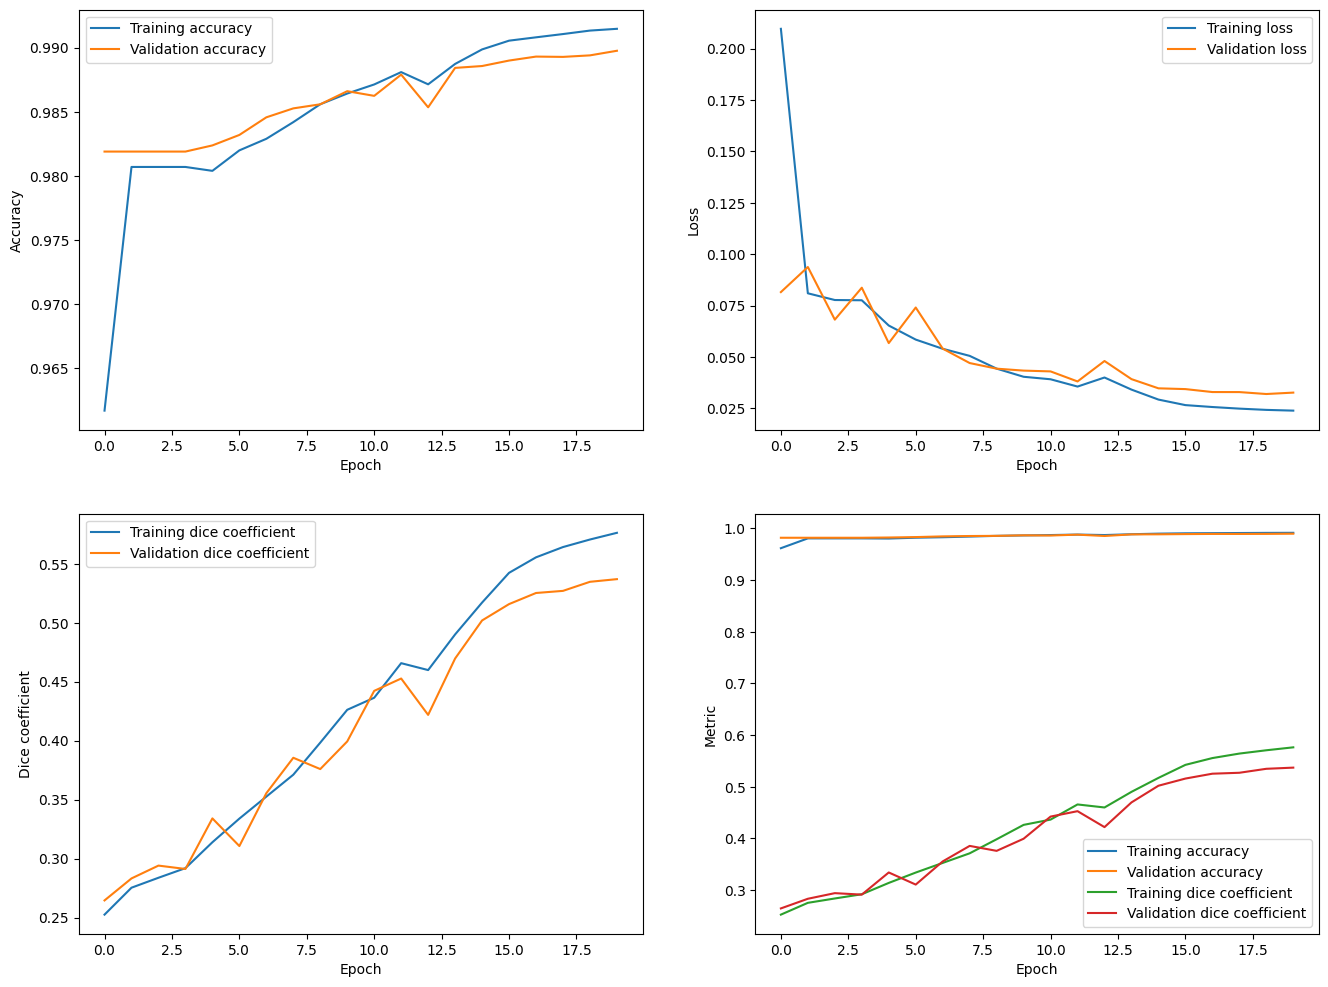

In [12]:
# Load the model
model = keras.models.load_model('/kaggle/input/bratsparts/u-net_part2.h5', 
                                custom_objects={ 'accuracy' : tf.keras.metrics.MeanIoU(num_classes=4),
                                                "dice_coef": dice_coef,
                                                "precision": precision,
                                                "sensitivity":sensitivity,
                                                "specificity":specificity,
                                                "dice_coef_necrotic": dice_coef_necrotic,
                                                "dice_coef_edema": dice_coef_edema,
                                                "dice_coef_enhancing": dice_coef_enhancing
                                               }, compile=False)

# Load the training history
history = pd.read_csv('/kaggle/input/bratsparts/egitim_part2.log', sep=',', engine='python')

# Plot the performance metrics
f, ax = plt.subplots(2, 2, figsize=(16, 12))

ax[0, 0].plot(history['accuracy'], label='Training accuracy')
ax[0, 0].plot(history['val_accuracy'], label='Validation accuracy')
ax[0, 0].set_xlabel('Epoch')
ax[0, 0].set_ylabel('Accuracy')
ax[0, 0].legend()

ax[0, 1].plot(history['loss'], label='Training loss')
ax[0, 1].plot(history['val_loss'], label='Validation loss')
ax[0, 1].set_xlabel('Epoch')
ax[0, 1].set_ylabel('Loss')
ax[0, 1].legend()

ax[1, 0].plot(history['dice_coef'], label='Training dice coefficient')
ax[1, 0].plot(history['val_dice_coef'], label='Validation dice coefficient')
ax[1, 0].set_xlabel('Epoch')
ax[1, 0].set_ylabel('Dice coefficient')
ax[1, 0].legend()

ax[1, 1].plot(history['accuracy'], label='Training accuracy')
ax[1, 1].plot(history['val_accuracy'], label='Validation accuracy')
ax[1, 1].plot(history['dice_coef'], label='Training dice coefficient')
ax[1, 1].plot(history['val_dice_coef'], label='Validation dice coefficient')
ax[1, 1].set_xlabel('Epoch')
ax[1, 1].set_ylabel('Metric')
ax[1, 1].legend()

plt.show()


4/4 [==============================] - 2s 505ms/step


<Figure size 1800x5000 with 0 Axes>

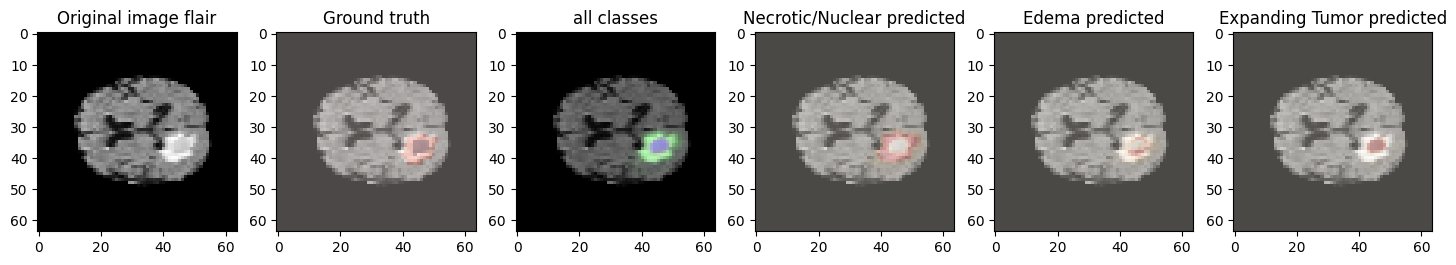

In [13]:
"""Bu kod, eğitilmiş bir modeli kullanarak bir dizinde saklanan MRI taramaları üzerinde tahminler yapmaya yönelik görünüyor.
Önce nib.load fonksiyonunu kullanarak tarama verilerini yükler.
Daha sonra, cv2.resize kullanılarak taramalar yeniden boyutlandırılır ve X olarak adlandırılan 3D bir diziye kaydedilir. 
predictByPath fonksiyonu daha sonra modeli kullanarak X üzerinde tahminler yapar ve tahminleri bir dizi olarak döndürür.
showPredictsById fonksiyonu, modelin yaptığı tahminleri görselleştirmeyi amaçlı görünüyor. Bu fonksiyon, taramalar için ground truth verilerini yükler"""


def predictByPath(case_path,case):
    files = next(os.walk(case_path))[2]
    X = np.empty((VOLUME_SLICES, IMG_SIZE, IMG_SIZE, 2))

    vol_path = os.path.join(case_path, f'BraTS19_2013_{case}_flair.nii');
    flair=nib.load(vol_path).get_fdata()

    vol_path = os.path.join(case_path, f'BraTS19_2013_{case}_t1ce.nii');
    ce=nib.load(vol_path).get_fdata() 

    for j in range(VOLUME_SLICES):
        X[j,:,:,0] = cv2.resize(flair[:,:,j+VOLUME_START_AT], (IMG_SIZE,IMG_SIZE))
        X[j,:,:,1] = cv2.resize(ce[:,:,j+VOLUME_START_AT], (IMG_SIZE,IMG_SIZE))
  
    return model.predict(X/np.max(X), verbose=1)

def showPredictsById(case, start_slice = 60):
    path = f"/kaggle/input/brain-tumor-segmentation-brats-2019/MICCAI_BraTS_2019_Data_Training/HGG/BraTS19_2013_{case}"
    gt = nib.load(os.path.join(path, f'BraTS19_2013_{case}_seg.nii')).get_fdata()
    origImage = nib.load(os.path.join(path, f'BraTS19_2013_{case}_flair.nii')).get_fdata()
    p = predictByPath(path,case)

    core = p[:,:,:,1]
    edema= p[:,:,:,2]
    enhancing = p[:,:,:,3]

    plt.figure(figsize=(18, 50))
    f, axarr = plt.subplots(1,6, figsize = (18, 50)) 

    for i in range(6):
        axarr[i].imshow(cv2.resize(origImage[:,:,start_slice+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE)),cmap="gray", interpolation='none')

    axarr[0].imshow(cv2.resize(origImage[:,:,start_slice+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE)), cmap="gray")
    axarr[0].title.set_text('Original image flair')
    curr_gt=cv2.resize(gt[:,:,start_slice+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE), interpolation = cv2.INTER_NEAREST)
    axarr[1].imshow(curr_gt, cmap="Reds", interpolation='none', alpha=0.3) # ,alpha=0.3,cmap='Reds'
    axarr[1].title.set_text('Ground truth')
    axarr[2].imshow(p[start_slice,:,:,1:4], cmap="Reds", interpolation='none', alpha=0.3)
    axarr[2].title.set_text('all classes')
    axarr[3].imshow(edema[start_slice,:,:], cmap="OrRd", interpolation='none', alpha=0.3)
    axarr[3].title.set_text(f'{SEGMENT_CLASSES[1]} predicted')
    axarr[4].imshow(core[start_slice,:,], cmap="OrRd", interpolation='none', alpha=0.3)
    axarr[4].title.set_text(f'{SEGMENT_CLASSES[2]} predicted')
    axarr[5].imshow(enhancing[start_slice,:,], cmap="OrRd", interpolation='none', alpha=0.3)
    axarr[5].title.set_text(f'{SEGMENT_CLASSES[3]} predicted')
    plt.show()


showPredictsById(case="5_1")#veri deneme


**Part 3 U-Net Model Segmentation**

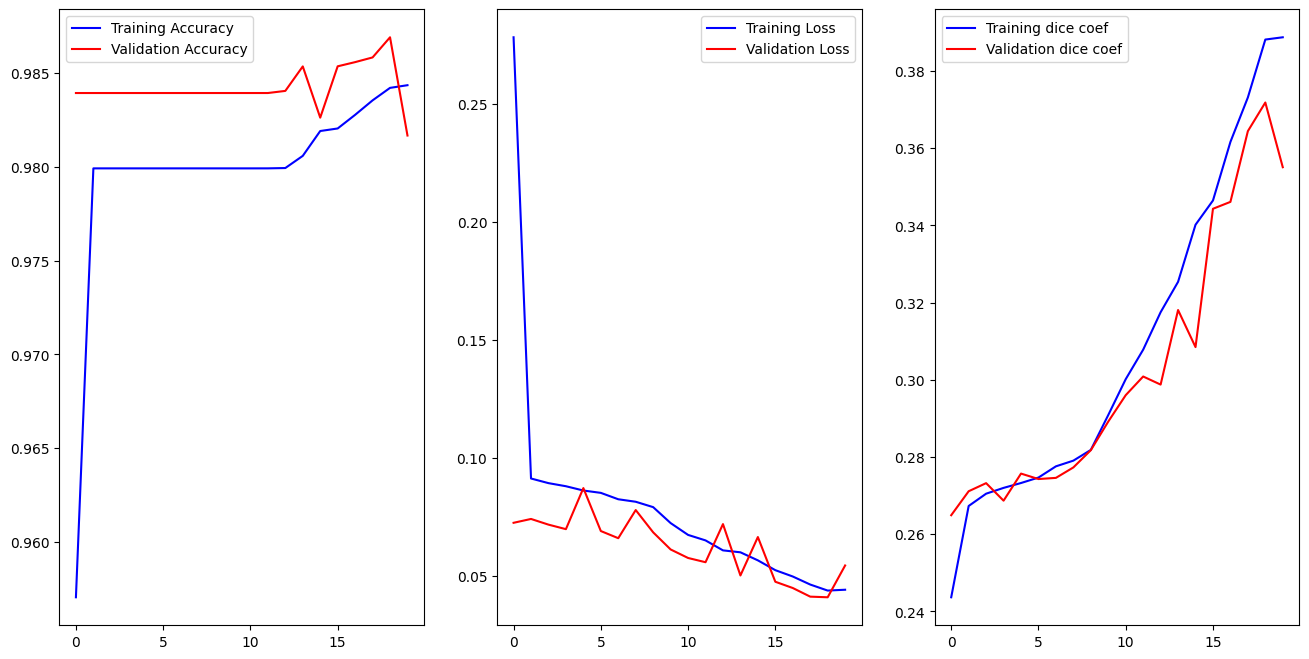

In [16]:
#Modelin yüklenmesi
#Modelin tahmin aşamasında kullanması için eğitim sonrası değerleri tekrar yükledik.
model = keras.models.load_model('/kaggle/input/bratsparts/u-net_part3.h5', 
                                   custom_objects={ 'accuracy' : tf.keras.metrics.MeanIoU(num_classes=4),
                                                   "dice_coef": dice_coef,
                                                   "precision": precision,
                                                   "sensitivity":sensitivity,
                                                   "specificity":specificity,
                                                   "dice_coef_necrotic": dice_coef_necrotic,
                                                   "dice_coef_edema": dice_coef_edema,
                                                   "dice_coef_enhancing": dice_coef_enhancing
                                                  }, compile=False)

#Eğitim sonrası bize grafikleri verdi 
history = pd.read_csv('/kaggle/input/bratsparts/egitim_part3.log', sep=',', engine='python')

hist=history



acc=hist['accuracy']
val_acc=hist['val_accuracy']

epoch=range(len(acc))

loss=hist['loss']
val_loss=hist['val_loss']

train_dice=hist['dice_coef']
val_dice=hist['val_dice_coef']

f,ax=plt.subplots(1,3,figsize=(16,8))

ax[0].plot(epoch,acc,'b',label='Training Accuracy')
ax[0].plot(epoch,val_acc,'r',label='Validation Accuracy')
ax[0].legend()

ax[1].plot(epoch,loss,'b',label='Training Loss')
ax[1].plot(epoch,val_loss,'r',label='Validation Loss')
ax[1].legend()

ax[2].plot(epoch,train_dice,'b',label='Training dice coef')
ax[2].plot(epoch,val_dice,'r',label='Validation dice coef')
ax[2].legend()


plt.show()

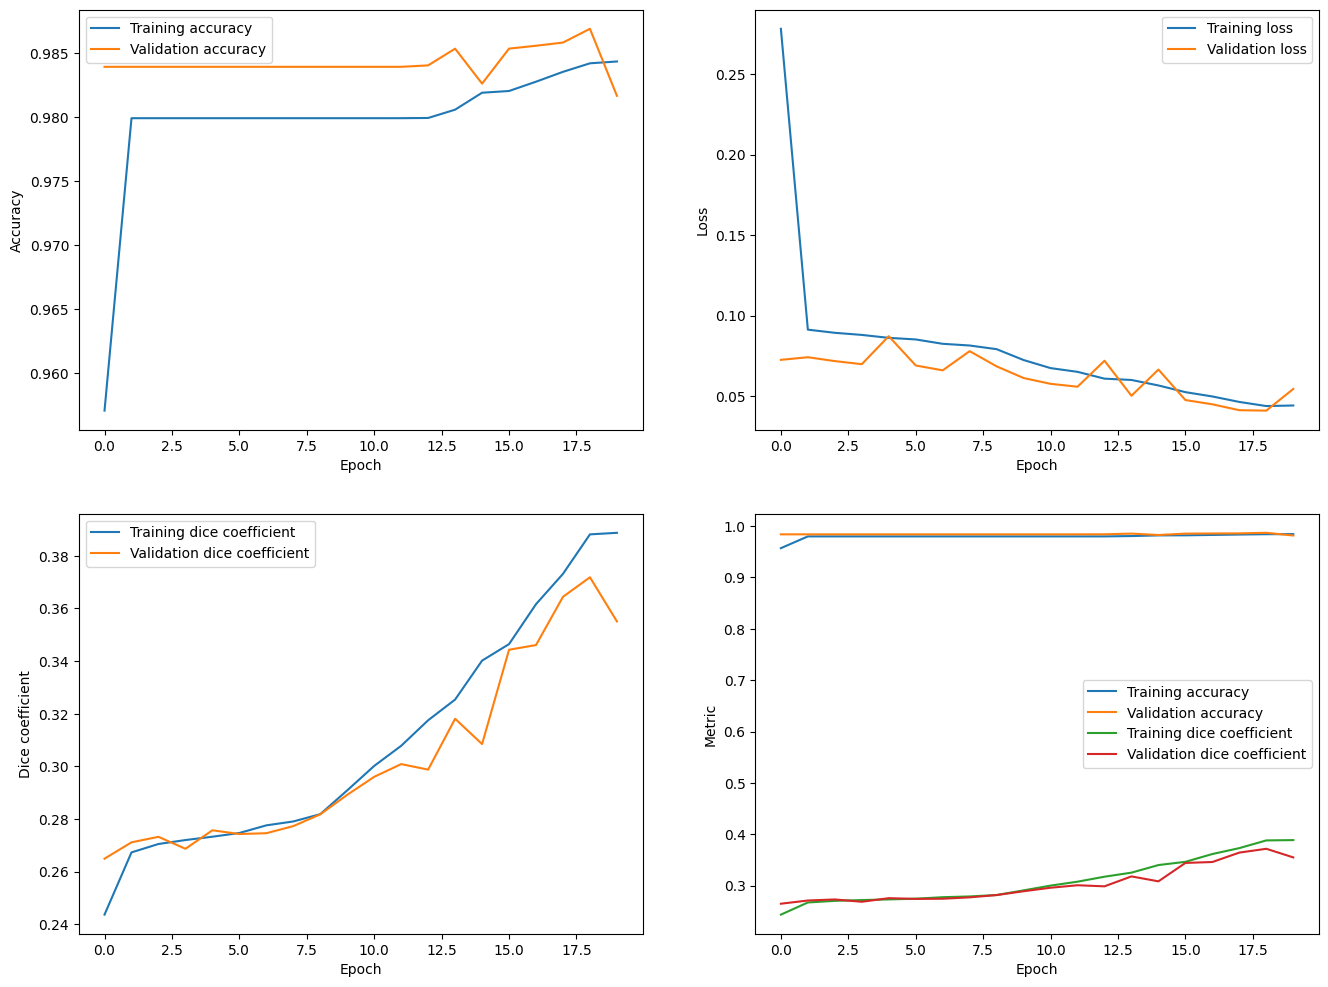

In [14]:
# Load the model
model = keras.models.load_model('/kaggle/input/bratsparts/u-net_part3.h5', 
                                custom_objects={ 'accuracy' : tf.keras.metrics.MeanIoU(num_classes=4),
                                                "dice_coef": dice_coef,
                                                "precision": precision,
                                                "sensitivity":sensitivity,
                                                "specificity":specificity,
                                                "dice_coef_necrotic": dice_coef_necrotic,
                                                "dice_coef_edema": dice_coef_edema,
                                                "dice_coef_enhancing": dice_coef_enhancing
                                               }, compile=False)

# Load the training history
history = pd.read_csv('/kaggle/input/bratsparts/egitim_part3.log', sep=',', engine='python')

# Plot the performance metrics
f, ax = plt.subplots(2, 2, figsize=(16, 12))

ax[0, 0].plot(history['accuracy'], label='Training accuracy')
ax[0, 0].plot(history['val_accuracy'], label='Validation accuracy')
ax[0, 0].set_xlabel('Epoch')
ax[0, 0].set_ylabel('Accuracy')
ax[0, 0].legend()

ax[0, 1].plot(history['loss'], label='Training loss')
ax[0, 1].plot(history['val_loss'], label='Validation loss')
ax[0, 1].set_xlabel('Epoch')
ax[0, 1].set_ylabel('Loss')
ax[0, 1].legend()

ax[1, 0].plot(history['dice_coef'], label='Training dice coefficient')
ax[1, 0].plot(history['val_dice_coef'], label='Validation dice coefficient')
ax[1, 0].set_xlabel('Epoch')
ax[1, 0].set_ylabel('Dice coefficient')
ax[1, 0].legend()

ax[1, 1].plot(history['accuracy'], label='Training accuracy')
ax[1, 1].plot(history['val_accuracy'], label='Validation accuracy')
ax[1, 1].plot(history['dice_coef'], label='Training dice coefficient')
ax[1, 1].plot(history['val_dice_coef'], label='Validation dice coefficient')
ax[1, 1].set_xlabel('Epoch')
ax[1, 1].set_ylabel('Metric')
ax[1, 1].legend()

plt.show()


4/4 [==============================] - 2s 384ms/step


<Figure size 1800x5000 with 0 Axes>

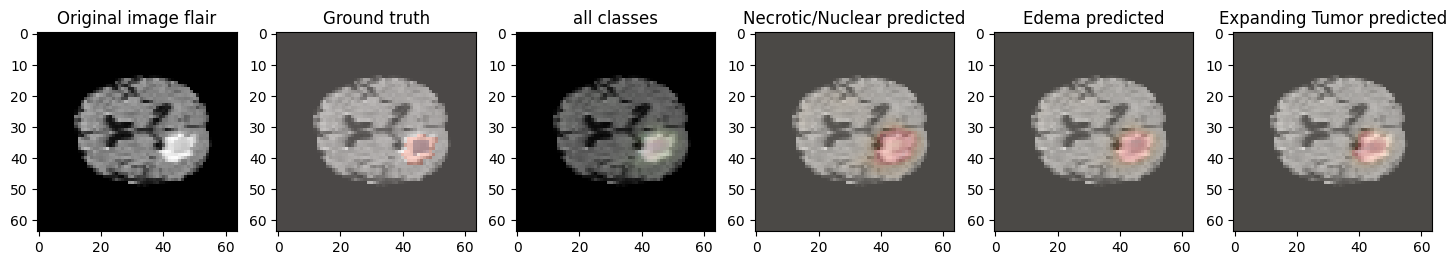

In [15]:
"""Bu kod, eğitilmiş bir modeli kullanarak bir dizinde saklanan MRI taramaları üzerinde tahminler yapmaya yönelik görünüyor.
Önce nib.load fonksiyonunu kullanarak tarama verilerini yükler.
Daha sonra, cv2.resize kullanılarak taramalar yeniden boyutlandırılır ve X olarak adlandırılan 3D bir diziye kaydedilir. 
predictByPath fonksiyonu daha sonra modeli kullanarak X üzerinde tahminler yapar ve tahminleri bir dizi olarak döndürür.
showPredictsById fonksiyonu, modelin yaptığı tahminleri görselleştirmeyi amaçlı görünüyor. Bu fonksiyon, taramalar için ground truth verilerini yükler"""


def predictByPath(case_path,case):
    files = next(os.walk(case_path))[2]
    X = np.empty((VOLUME_SLICES, IMG_SIZE, IMG_SIZE, 2))

    vol_path = os.path.join(case_path, f'BraTS19_2013_{case}_flair.nii');
    flair=nib.load(vol_path).get_fdata()

    vol_path = os.path.join(case_path, f'BraTS19_2013_{case}_t1ce.nii');
    ce=nib.load(vol_path).get_fdata() 

    for j in range(VOLUME_SLICES):
        X[j,:,:,0] = cv2.resize(flair[:,:,j+VOLUME_START_AT], (IMG_SIZE,IMG_SIZE))
        X[j,:,:,1] = cv2.resize(ce[:,:,j+VOLUME_START_AT], (IMG_SIZE,IMG_SIZE))
  
    return model.predict(X/np.max(X), verbose=1)

def showPredictsById(case, start_slice = 60):
    path = f"/kaggle/input/brain-tumor-segmentation-brats-2019/MICCAI_BraTS_2019_Data_Training/HGG/BraTS19_2013_{case}"
    gt = nib.load(os.path.join(path, f'BraTS19_2013_{case}_seg.nii')).get_fdata()
    origImage = nib.load(os.path.join(path, f'BraTS19_2013_{case}_flair.nii')).get_fdata()
    p = predictByPath(path,case)

    core = p[:,:,:,1]
    edema= p[:,:,:,2]
    enhancing = p[:,:,:,3]

    plt.figure(figsize=(18, 50))
    f, axarr = plt.subplots(1,6, figsize = (18, 50)) 

    for i in range(6):
        axarr[i].imshow(cv2.resize(origImage[:,:,start_slice+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE)),cmap="gray", interpolation='none')

    axarr[0].imshow(cv2.resize(origImage[:,:,start_slice+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE)), cmap="gray")
    axarr[0].title.set_text('Original image flair')
    curr_gt=cv2.resize(gt[:,:,start_slice+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE), interpolation = cv2.INTER_NEAREST)
    axarr[1].imshow(curr_gt, cmap="Reds", interpolation='none', alpha=0.3) # ,alpha=0.3,cmap='Reds'
    axarr[1].title.set_text('Ground truth')
    axarr[2].imshow(p[start_slice,:,:,1:4], cmap="Reds", interpolation='none', alpha=0.3)
    axarr[2].title.set_text('all classes')
    axarr[3].imshow(edema[start_slice,:,:], cmap="OrRd", interpolation='none', alpha=0.3)
    axarr[3].title.set_text(f'{SEGMENT_CLASSES[1]} predicted')
    axarr[4].imshow(core[start_slice,:,], cmap="OrRd", interpolation='none', alpha=0.3)
    axarr[4].title.set_text(f'{SEGMENT_CLASSES[2]} predicted')
    axarr[5].imshow(enhancing[start_slice,:,], cmap="OrRd", interpolation='none', alpha=0.3)
    axarr[5].title.set_text(f'{SEGMENT_CLASSES[3]} predicted')
    plt.show()


showPredictsById(case="5_1")#veri deneme


**Global Model Visualization**

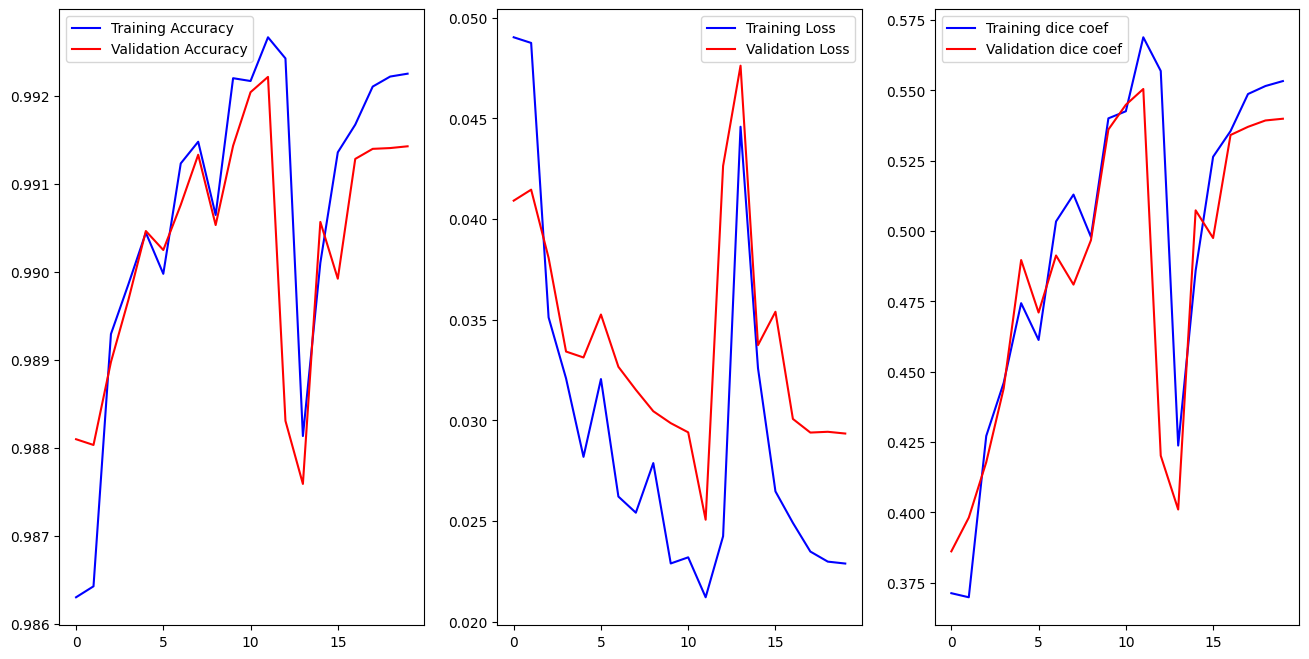

In [25]:
#Modelin yüklenmesi
#Modelin tahmin aşamasında kullanması için eğitim sonrası değerleri tekrar yükledik.
model = keras.models.load_model('/kaggle/input/bratsparts/u-net_global_train.h5', 
                                   custom_objects={ 'accuracy' : tf.keras.metrics.MeanIoU(num_classes=4),
                                                   "dice_coef": dice_coef,
                                                   "precision": precision,
                                                   "sensitivity":sensitivity,
                                                   "specificity":specificity,
                                                   "dice_coef_necrotic": dice_coef_necrotic,
                                                   "dice_coef_edema": dice_coef_edema,
                                                   "dice_coef_enhancing": dice_coef_enhancing
                                                  }, compile=False)

#Eğitim sonrası bize grafikleri verdi 
history = pd.read_csv('/kaggle/input/bratsparts/egitim_global.log', sep=',', engine='python')

hist=history



acc=hist['accuracy']
val_acc=hist['val_accuracy']

epoch=range(len(acc))

loss=hist['loss']
val_loss=hist['val_loss']

train_dice=hist['dice_coef']
val_dice=hist['val_dice_coef']

f,ax=plt.subplots(1,3,figsize=(16,8))

ax[0].plot(epoch,acc,'b',label='Training Accuracy')
ax[0].plot(epoch,val_acc,'r',label='Validation Accuracy')
ax[0].legend()

ax[1].plot(epoch,loss,'b',label='Training Loss')
ax[1].plot(epoch,val_loss,'r',label='Validation Loss')
ax[1].legend()

ax[2].plot(epoch,train_dice,'b',label='Training dice coef')
ax[2].plot(epoch,val_dice,'r',label='Validation dice coef')
ax[2].legend()


plt.show()

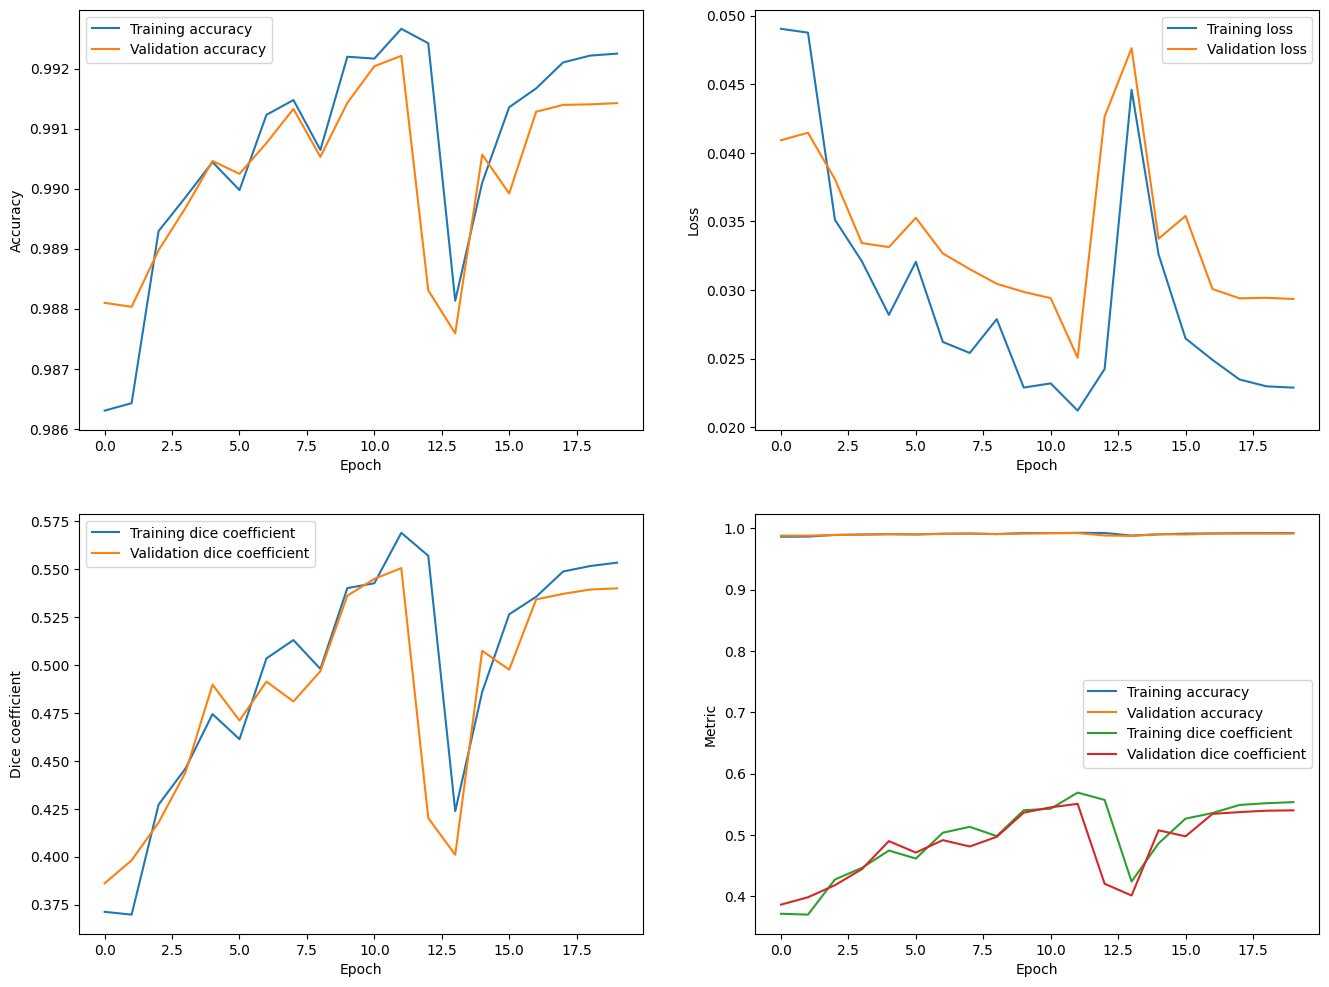

In [26]:
# Load the model
model = keras.models.load_model('/kaggle/input/bratsparts/u-net_global_train.h5', 
                                custom_objects={ 'accuracy' : tf.keras.metrics.MeanIoU(num_classes=4),
                                                "dice_coef": dice_coef,
                                                "precision": precision,
                                                "sensitivity":sensitivity,
                                                "specificity":specificity,
                                                "dice_coef_necrotic": dice_coef_necrotic,
                                                "dice_coef_edema": dice_coef_edema,
                                                "dice_coef_enhancing": dice_coef_enhancing
                                               }, compile=False)

# Load the training history
history = pd.read_csv('/kaggle/input/bratsparts/egitim_global.log', sep=',', engine='python')

# Plot the performance metrics
f, ax = plt.subplots(2, 2, figsize=(16, 12))

ax[0, 0].plot(history['accuracy'], label='Training accuracy')
ax[0, 0].plot(history['val_accuracy'], label='Validation accuracy')
ax[0, 0].set_xlabel('Epoch')
ax[0, 0].set_ylabel('Accuracy')
ax[0, 0].legend()

ax[0, 1].plot(history['loss'], label='Training loss')
ax[0, 1].plot(history['val_loss'], label='Validation loss')
ax[0, 1].set_xlabel('Epoch')
ax[0, 1].set_ylabel('Loss')
ax[0, 1].legend()

ax[1, 0].plot(history['dice_coef'], label='Training dice coefficient')
ax[1, 0].plot(history['val_dice_coef'], label='Validation dice coefficient')
ax[1, 0].set_xlabel('Epoch')
ax[1, 0].set_ylabel('Dice coefficient')
ax[1, 0].legend()

ax[1, 1].plot(history['accuracy'], label='Training accuracy')
ax[1, 1].plot(history['val_accuracy'], label='Validation accuracy')
ax[1, 1].plot(history['dice_coef'], label='Training dice coefficient')
ax[1, 1].plot(history['val_dice_coef'], label='Validation dice coefficient')
ax[1, 1].set_xlabel('Epoch')
ax[1, 1].set_ylabel('Metric')
ax[1, 1].legend()

plt.show()


4/4 [==============================] - 2s 396ms/step


<Figure size 1800x5000 with 0 Axes>

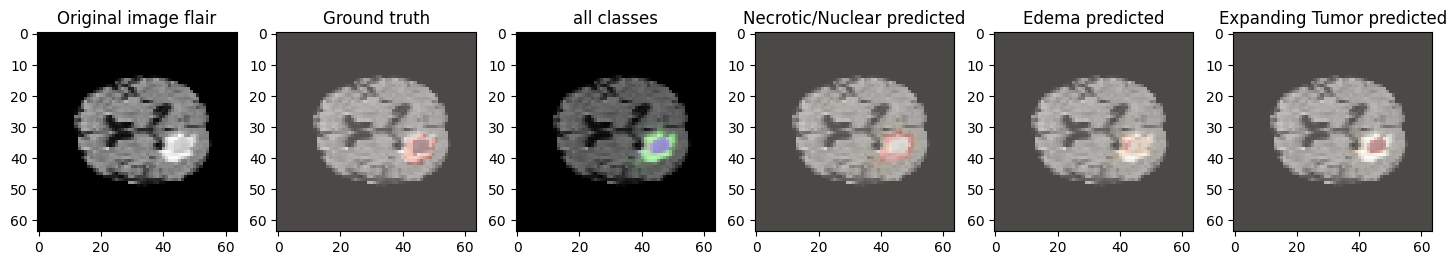

In [27]:
"""Bu kod, eğitilmiş bir modeli kullanarak bir dizinde saklanan MRI taramaları üzerinde tahminler yapmaya yönelik görünüyor.
Önce nib.load fonksiyonunu kullanarak tarama verilerini yükler.
Daha sonra, cv2.resize kullanılarak taramalar yeniden boyutlandırılır ve X olarak adlandırılan 3D bir diziye kaydedilir. 
predictByPath fonksiyonu daha sonra modeli kullanarak X üzerinde tahminler yapar ve tahminleri bir dizi olarak döndürür.
showPredictsById fonksiyonu, modelin yaptığı tahminleri görselleştirmeyi amaçlı görünüyor. Bu fonksiyon, taramalar için ground truth verilerini yükler"""


def predictByPath(case_path,case):
    files = next(os.walk(case_path))[2]
    X = np.empty((VOLUME_SLICES, IMG_SIZE, IMG_SIZE, 2))

    vol_path = os.path.join(case_path, f'BraTS19_2013_{case}_flair.nii');
    flair=nib.load(vol_path).get_fdata()

    vol_path = os.path.join(case_path, f'BraTS19_2013_{case}_t1ce.nii');
    ce=nib.load(vol_path).get_fdata() 

    for j in range(VOLUME_SLICES):
        X[j,:,:,0] = cv2.resize(flair[:,:,j+VOLUME_START_AT], (IMG_SIZE,IMG_SIZE))
        X[j,:,:,1] = cv2.resize(ce[:,:,j+VOLUME_START_AT], (IMG_SIZE,IMG_SIZE))
  
    return model.predict(X/np.max(X), verbose=1)

def showPredictsById(case, start_slice = 60):
    path = f"/kaggle/input/brain-tumor-segmentation-brats-2019/MICCAI_BraTS_2019_Data_Training/HGG/BraTS19_2013_{case}"
    gt = nib.load(os.path.join(path, f'BraTS19_2013_{case}_seg.nii')).get_fdata()
    origImage = nib.load(os.path.join(path, f'BraTS19_2013_{case}_flair.nii')).get_fdata()
    p = predictByPath(path,case)

    core = p[:,:,:,1]
    edema= p[:,:,:,2]
    enhancing = p[:,:,:,3]

    plt.figure(figsize=(18, 50))
    f, axarr = plt.subplots(1,6, figsize = (18, 50)) 

    for i in range(6):
        axarr[i].imshow(cv2.resize(origImage[:,:,start_slice+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE)),cmap="gray", interpolation='none')

    axarr[0].imshow(cv2.resize(origImage[:,:,start_slice+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE)), cmap="gray")
    axarr[0].title.set_text('Original image flair')
    curr_gt=cv2.resize(gt[:,:,start_slice+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE), interpolation = cv2.INTER_NEAREST)
    axarr[1].imshow(curr_gt, cmap="Reds", interpolation='none', alpha=0.3) # ,alpha=0.3,cmap='Reds'
    axarr[1].title.set_text('Ground truth')
    axarr[2].imshow(p[start_slice,:,:,1:4], cmap="Reds", interpolation='none', alpha=0.3)
    axarr[2].title.set_text('all classes')
    axarr[3].imshow(edema[start_slice,:,:], cmap="OrRd", interpolation='none', alpha=0.3)
    axarr[3].title.set_text(f'{SEGMENT_CLASSES[1]} predicted')
    axarr[4].imshow(core[start_slice,:,], cmap="OrRd", interpolation='none', alpha=0.3)
    axarr[4].title.set_text(f'{SEGMENT_CLASSES[2]} predicted')
    axarr[5].imshow(enhancing[start_slice,:,], cmap="OrRd", interpolation='none', alpha=0.3)
    axarr[5].title.set_text(f'{SEGMENT_CLASSES[3]} predicted')
    plt.show()


showPredictsById(case="5_1")#veri deneme


**Compare SidebySide 3 Models**

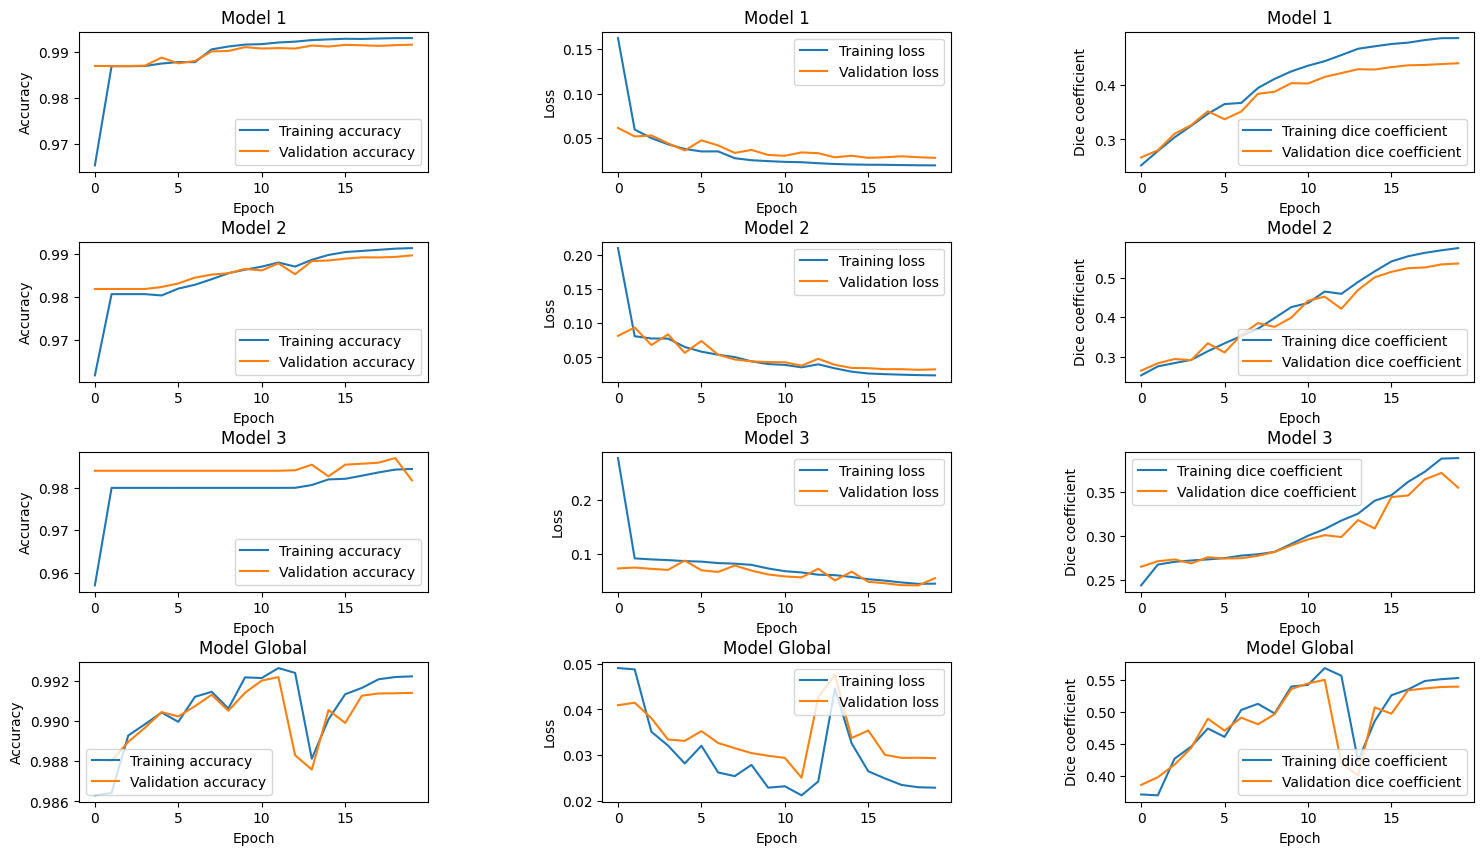

In [28]:
# Load the models
model1 = keras.models.load_model('/kaggle/input/bratsparts/u-net_part1.h5', 
                                custom_objects={ 'accuracy' : tf.keras.metrics.MeanIoU(num_classes=4),
                                                "dice_coef": dice_coef,
                                                "precision": precision,
                                                "sensitivity":sensitivity,
                                                "specificity":specificity,
                                                "dice_coef_necrotic": dice_coef_necrotic,
                                                "dice_coef_edema": dice_coef_edema,
                                                "dice_coef_enhancing": dice_coef_enhancing
                                               }, compile=False)

model2 = keras.models.load_model('/kaggle/input/bratsparts/u-net_part2.h5', 
                                custom_objects={ 'accuracy' : tf.keras.metrics.MeanIoU(num_classes=4),
                                                "dice_coef": dice_coef,
                                                "precision": precision,
                                                "sensitivity":sensitivity,
                                                "specificity":specificity,
                                                "dice_coef_necrotic": dice_coef_necrotic,
                                                "dice_coef_edema": dice_coef_edema,
                                                "dice_coef_enhancing": dice_coef_enhancing
                                               }, compile=False)

model3 = keras.models.load_model('/kaggle/input/bratsparts/u-net_part3.h5', 
                                custom_objects={ 'accuracy' : tf.keras.metrics.MeanIoU(num_classes=4),
                                                "dice_coef": dice_coef,
                                                "precision": precision,
                                                "sensitivity":sensitivity,
                                                "specificity":specificity,
                                                "dice_coef_necrotic": dice_coef_necrotic,
                                                "dice_coef_edema": dice_coef_edema,
                                                "dice_coef_enhancing": dice_coef_enhancing
                                               }, compile=False)

model_global = keras.models.load_model('/kaggle/input/bratsparts/u-net_global_train.h5', 
                                custom_objects={ 'accuracy' : tf.keras.metrics.MeanIoU(num_classes=4),
                                                "dice_coef": dice_coef,
                                                "precision": precision,
                                                "sensitivity":sensitivity,
                                                "specificity":specificity,
                                                "dice_coef_necrotic": dice_coef_necrotic,
                                                "dice_coef_edema": dice_coef_edema,
                                                "dice_coef_enhancing": dice_coef_enhancing
                                               }, compile=False)

# Load the training histories
history1 = pd.read_csv('/kaggle/input/bratsparts/egitim_part1.log', sep=',', engine='python')
history2 = pd.read_csv('/kaggle/input/bratsparts/egitim_part2.log', sep=',', engine='python')
history3 = pd.read_csv('/kaggle/input/bratsparts/egitim_part3.log', sep=',', engine='python')
history_global = pd.read_csv('/kaggle/input/bratsparts/egitim_global.log', sep=',', engine='python')



# Plot the performance metrics side by side
fig, axs = plt.subplots(4, 3, figsize=(18, 10))

axs[0, 0].plot(history1['accuracy'], label='Training accuracy')
axs[0, 0].plot(history1['val_accuracy'], label='Validation accuracy')
axs[0, 0].set_xlabel('Epoch')
axs[0, 0].set_ylabel('Accuracy')
axs[0, 0].set_title('Model 1')
axs[0, 0].legend()

axs[0, 1].plot(history1['loss'], label='Training loss')
axs[0, 1].plot(history1['val_loss'], label='Validation loss')
axs[0, 1].set_xlabel('Epoch')
axs[0, 1].set_ylabel('Loss')
axs[0, 1].set_title('Model 1')
axs[0, 1].legend()

axs[0, 2].plot(history1['dice_coef'], label='Training dice coefficient')
axs[0, 2].plot(history1['val_dice_coef'], label='Validation dice coefficient')
axs[0, 2].set_xlabel('Epoch')
axs[0, 2].set_ylabel('Dice coefficient')
axs[0, 2].set_title('Model 1')
axs[0, 2].legend()

axs[1, 0].plot(history2['accuracy'], label='Training accuracy')
axs[1, 0].plot(history2['val_accuracy'], label='Validation accuracy')
axs[1, 0].set_xlabel('Epoch')
axs[1, 0].set_ylabel('Accuracy')
axs[1, 0].set_title('Model 2')
axs[1, 0].legend()

axs[1, 1].plot(history2['loss'], label='Training loss')
axs[1, 1].plot(history2['val_loss'], label='Validation loss')
axs[1, 1].set_xlabel('Epoch')
axs[1, 1].set_ylabel('Loss')
axs[1, 1].set_title('Model 2')
axs[1, 1].legend()

axs[1, 2].plot(history2['dice_coef'], label='Training dice coefficient')
axs[1, 2].plot(history2['val_dice_coef'], label='Validation dice coefficient')
axs[1, 2].set_xlabel('Epoch')
axs[1, 2].set_ylabel('Dice coefficient')
axs[1, 2].set_title('Model 2')
axs[1, 2].legend()

axs[2, 0].plot(history3['accuracy'], label='Training accuracy')
axs[2, 0].plot(history3['val_accuracy'], label='Validation accuracy')
axs[2, 0].set_xlabel('Epoch')
axs[2, 0].set_ylabel('Accuracy')
axs[2, 0].set_title('Model 3')
axs[2, 0].legend()

axs[2, 1].plot(history3['loss'], label='Training loss')
axs[2, 1].plot(history3['val_loss'], label='Validation loss')
axs[2, 1].set_xlabel('Epoch')
axs[2, 1].set_ylabel('Loss')
axs[2, 1].set_title('Model 3')
axs[2, 1].legend()

axs[2, 2].plot(history3['dice_coef'], label='Training dice coefficient')
axs[2, 2].plot(history3['val_dice_coef'], label='Validation dice coefficient')
axs[2, 2].set_xlabel('Epoch')
axs[2, 2].set_ylabel('Dice coefficient')
axs[2, 2].set_title('Model 3')
axs[2, 2].legend()

axs[3, 0].plot(history_global['accuracy'], label='Training accuracy')
axs[3, 0].plot(history_global['val_accuracy'], label='Validation accuracy')
axs[3, 0].set_xlabel('Epoch')
axs[3, 0].set_ylabel('Accuracy')
axs[3, 0].set_title('Model Global')
axs[3, 0].legend()

axs[3, 1].plot(history_global['loss'], label='Training loss')
axs[3, 1].plot(history_global['val_loss'], label='Validation loss')
axs[3, 1].set_xlabel('Epoch')
axs[3, 1].set_ylabel('Loss')
axs[3, 1].set_title('Model Global')
axs[3, 1].legend()

axs[3, 2].plot(history_global['dice_coef'], label='Training dice coefficient')
axs[3, 2].plot(history_global['val_dice_coef'], label='Validation dice coefficient')
axs[3, 2].set_xlabel('Epoch')
axs[3, 2].set_ylabel('Dice coefficient')
axs[3, 2].set_title('Model Global')
axs[3, 2].legend()

# Adjust the spacing between subplots
plt.subplots_adjust(wspace=0.5)
plt.subplots_adjust(hspace=0.5)

plt.show()

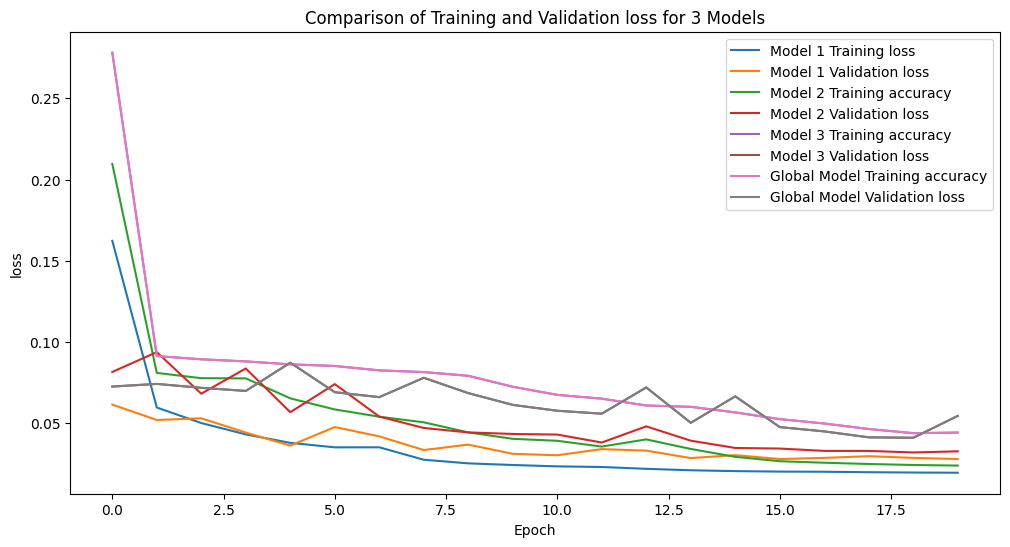

In [29]:
# Plot the performance metrics side by side
fig, axs = plt.subplots(1, 1, figsize=(12, 6))

axs.plot(history1['loss'], label='Model 1 Training loss')
axs.plot(history1['val_loss'], label='Model 1 Validation loss')

axs.plot(history2['loss'], label='Model 2 Training accuracy')
axs.plot(history2['val_loss'], label='Model 2 Validation loss')

axs.plot(history3['loss'], label='Model 3 Training accuracy')
axs.plot(history3['val_loss'], label='Model 3 Validation loss')

axs.plot(history3['loss'], label='Global Model Training accuracy')
axs.plot(history3['val_loss'], label='Global Model Validation loss')

axs.set_xlabel('Epoch')
axs.set_ylabel('loss')
axs.set_title('Comparison of Training and Validation loss for 3 Models')
axs.legend()
plt.show()

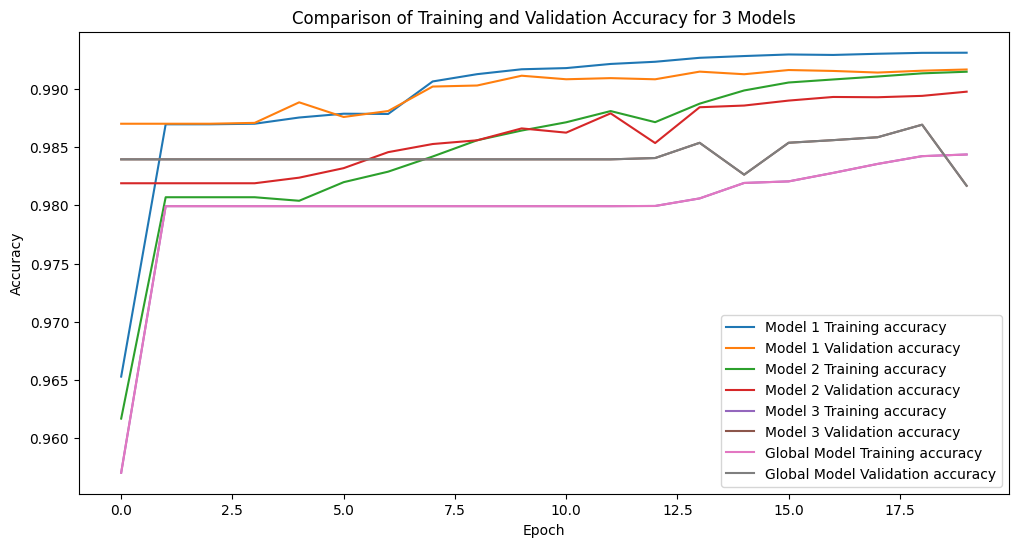

In [30]:
# Plot the performance metrics side by side
fig, axs = plt.subplots(1, 1, figsize=(12, 6))

axs.plot(history1['accuracy'], label='Model 1 Training accuracy')
axs.plot(history1['val_accuracy'], label='Model 1 Validation accuracy')

axs.plot(history2['accuracy'], label='Model 2 Training accuracy')
axs.plot(history2['val_accuracy'], label='Model 2 Validation accuracy')

axs.plot(history3['accuracy'], label='Model 3 Training accuracy')
axs.plot(history3['val_accuracy'], label='Model 3 Validation accuracy')

axs.plot(history3['accuracy'], label='Global Model Training accuracy')
axs.plot(history3['val_accuracy'], label='Global Model Validation accuracy')

axs.set_xlabel('Epoch')
axs.set_ylabel('Accuracy')
axs.set_title('Comparison of Training and Validation Accuracy for 3 Models')
axs.legend()
plt.show()

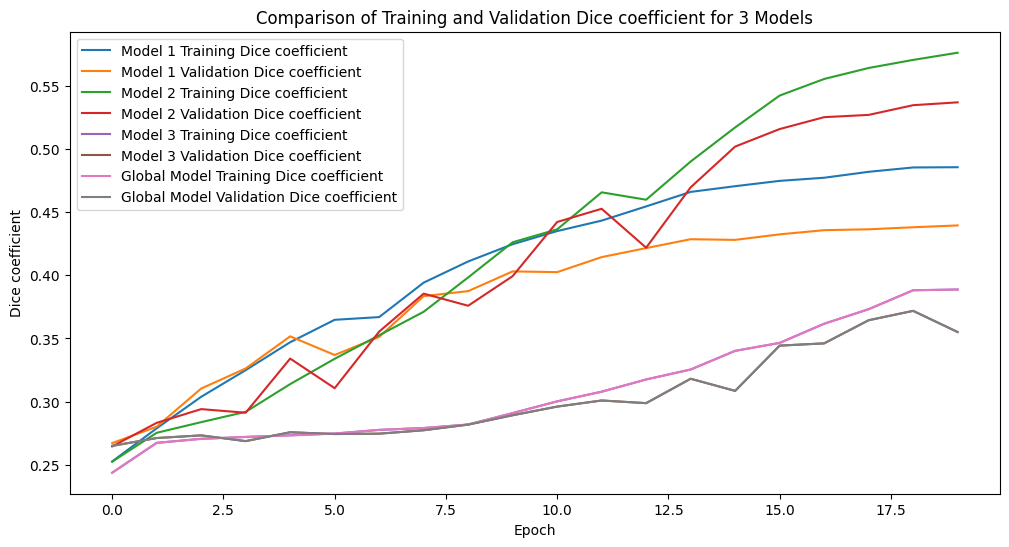

In [31]:
# Plot the performance metrics side by side
fig, axs = plt.subplots(1, 1, figsize=(12, 6))

axs.plot(history1['dice_coef'], label='Model 1 Training Dice coefficient')
axs.plot(history1['val_dice_coef'], label='Model 1 Validation Dice coefficient')

axs.plot(history2['dice_coef'], label='Model 2 Training Dice coefficient')
axs.plot(history2['val_dice_coef'], label='Model 2 Validation Dice coefficient')

axs.plot(history3['dice_coef'], label='Model 3 Training Dice coefficient')
axs.plot(history3['val_dice_coef'], label='Model 3 Validation Dice coefficient')

axs.plot(history3['dice_coef'], label='Global Model Training Dice coefficient')
axs.plot(history3['val_dice_coef'], label='Global Model Validation Dice coefficient')

axs.set_xlabel('Epoch')
axs.set_ylabel('Dice coefficient')
axs.set_title('Comparison of Training and Validation Dice coefficient for 3 Models')
axs.legend()
plt.show()

In [32]:
import pandas as pd

# Extract final epoch metrics
def extract_final_metrics(history):
    final_epoch = history.iloc[-1]
    metrics = {
        "Training Accuracy": final_epoch["accuracy"],
        "Validation Accuracy": final_epoch["val_accuracy"],
        "Training Loss": final_epoch["loss"],
        "Validation Loss": final_epoch["val_loss"],
        "Training Dice Coefficient": final_epoch["dice_coef"],
        "Validation Dice Coefficient": final_epoch["val_dice_coef"],
    }
    return metrics

# Create a DataFrame to store metrics
metrics_table = pd.DataFrame(columns=["Model", "Training Accuracy", "Validation Accuracy",
                                      "Training Loss", "Validation Loss",
                                      "Training Dice Coefficient", "Validation Dice Coefficient"])

# Extract metrics from each model's history
metrics_model1 = extract_final_metrics(history1)
metrics_model2 = extract_final_metrics(history2)
metrics_model3 = extract_final_metrics(history3)
metrics_global = extract_final_metrics(history_global)

# Add metrics to the DataFrame
metrics_table = metrics_table.append({**{"Model": "Model 1"}, **metrics_model1}, ignore_index=True)
metrics_table = metrics_table.append({**{"Model": "Model 2"}, **metrics_model2}, ignore_index=True)
metrics_table = metrics_table.append({**{"Model": "Model 3"}, **metrics_model3}, ignore_index=True)
metrics_table = metrics_table.append({**{"Model": "Model Global"}, **metrics_global}, ignore_index=True)

# Display the table
print(metrics_table)


          Model  Training Accuracy  Validation Accuracy  Training Loss  \
0       Model 1           0.993098             0.991659       0.019501   
1       Model 2           0.991466             0.989754       0.023902   
2       Model 3           0.984362             0.981677       0.044210   
3  Model Global           0.992251             0.991426       0.022889   

   Validation Loss  Training Dice Coefficient  Validation Dice Coefficient  
0         0.027925                   0.485602                     0.439509  
1         0.032668                   0.576268                     0.536979  
2         0.054481                   0.388750                     0.355090  
3         0.029348                   0.553314                     0.539925  


/tmp/ipykernel_34/2134074659.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_table = metrics_table.append({**{"Model": "Model 1"}, **metrics_model1}, ignore_index=True)
/tmp/ipykernel_34/2134074659.py:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_table = metrics_table.append({**{"Model": "Model 2"}, **metrics_model2}, ignore_index=True)
/tmp/ipykernel_34/2134074659.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_table = metrics_table.append({**{"Model": "Model 3"}, **metrics_model3}, ignore_index=True)
/tmp/ipykernel_34/2134074659.py:31: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_table = 

**Retrain with Global Model that used Brats 2019 Dataset**

Based on the updated table provided, we can summarize the performance of the 4 models as follows:

1. **Model 1**: This model has the highest training accuracy (99.31%) and the second-highest validation accuracy (99.17%). It has a relatively low training loss (0.0195) and validation loss (0.0279). The training dice coefficient is 0.4856, and the validation dice coefficient is 0.4395.

2. **Model 2**: Model 2 shows a slightly lower training accuracy (99.15%) and validation accuracy (98.98%) compared to Model 1. The training loss is 0.0239, and the validation loss is 0.0327. This model has the highest training dice coefficient (0.5763) and validation dice coefficient (0.5370) among all models.

3. **Model 3**: This model has the lowest training accuracy (98.44%) and validation accuracy (98.17%) among the models. It also has the highest training loss (0.0442) and validation loss (0.0545). The training dice coefficient is 0.3888, and the validation dice coefficient is 0.3551, which are the lowest among all models.

4. **Model Global**: The global model, created by aggregating the other models using federated learning, has a training accuracy of 99.23% and the highest validation accuracy (99.14%). It has a training loss of 0.0229 and a validation loss of 0.0293, which is higher than Model 1 but lower than the other models. The training dice coefficient is 0.5533, and the validation dice coefficient is 0.5399, which are both higher than Model 1 and Model 3 but slightly lower than Model 2.

In summary, the global model has the best overall performance in terms of validation accuracy. Model 2 has the highest dice coefficients, which could be useful depending on the specific requirements of your application. Model 1 has the lowest validation loss, so it might perform better in terms of generalization.


Given that Model 1, Model 2, and Model 3 are trained on the BraTS 2020 dataset, and the global model is retrained using the BraTS 2019 dataset, we can draw the following conclusions:

1. **Model Global**: The fact that the global model has the highest validation accuracy (99.14%) despite being retrained on the BraTS 2019 dataset indicates that the model has generalized well across different datasets. This suggests that the federated learning approach is effective in combining the knowledge of the three individual models, resulting in a better overall performance.

2. **Individual Models**: Since the three individual models (Model 1, Model 2, and Model 3) are trained on the BraTS 2020 dataset, their performance metrics are specific to that dataset. Comparing the individual models, Model 2 has the highest training and validation dice coefficients, making it the best-performing model in terms of segmentation quality. Model 1 has the lowest validation loss, so it might perform better in terms of generalization.

It is essential to note that the global model's performance indicates that it could be a better choice for applications that require a model that generalizes well across different datasets. However, if the primary concern is segmentation quality, Model 2 seems to be the best choice among the individual models.

**Old One With Global Part 1**

Based on the table provided, we can summarize the performance of the 4 models as follows:

1. **Model 1**: This model has the highest training accuracy (99.31%) and second-highest validation accuracy (99.17%). It has a relatively low training loss (0.0195) and validation loss (0.0279). The training dice coefficient is 0.4856, and the validation dice coefficient is 0.4395.

2. **Model 2**: Model 2 shows a slightly lower training accuracy (99.15%) and validation accuracy (98.98%) compared to Model 1. The training loss is 0.0239, and the validation loss is 0.0327. This model has the highest training dice coefficient (0.5763) and validation dice coefficient (0.5370) among all models.

3. **Model 3**: This model has the lowest training accuracy (98.44%) and validation accuracy (98.17%) among the models. It also has the highest training loss (0.0442) and validation loss (0.0545). The training dice coefficient is 0.3888, and the validation dice coefficient is 0.3551, which are the lowest among all models.

4. **Model Global**: The global model, created by aggregating the other models using federated learning, has a training accuracy of 99.23% and the highest validation accuracy (99.32%). It has a training loss of 0.0211 and the lowest validation loss (0.0209). The training dice coefficient is 0.4616, and the validation dice coefficient is 0.4713.

In summary, the global model has the best overall performance, with the highest validation accuracy and the lowest validation loss. Model 2 has the highest dice coefficients, which could be useful depending on the specific requirements of your application.

In [35]:
print(tf.__version__)

2.11.0
